In [1]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy_minimize_m3 as m3

/home/rebeccaz/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setting Up Initial Instrument Parameters

In [2]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load .csv files

In [3]:
csv_directory = '../../../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Plotting in Horizontal Reference Frame

In [4]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Comes out as a rotation offset
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502
Fixed Params:  [0, 0, -2.5, 0.451, -2.642, 0.32, -0.011, -0.163, 0.036, -7.151, 0.302, 0.256, 0.423]
FL1: [[ 0.21885504 -0.11425114 -0.17856116 -0.05440697]
 [ 0.21885504 -0.11425114 -0.17856116 -0.05440697]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR1: [[ 0.4826122   0.24423499  0.39809455  0.12159166]
 [-0.4826122  -0.24423499 -0.39809455 -0.12159166]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FL2: [[ 0.20915505  0.02721292  0.10855554 -0.17669462]
 [ 0.20915505  0.02721292  0.10855554 -0.17669462]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR2: [[ 0.50554361 -0.09019541 -0.28066832  0.41068775]
 [-0.50554361  0.09019541  0.28066832 -0.41068775]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.   

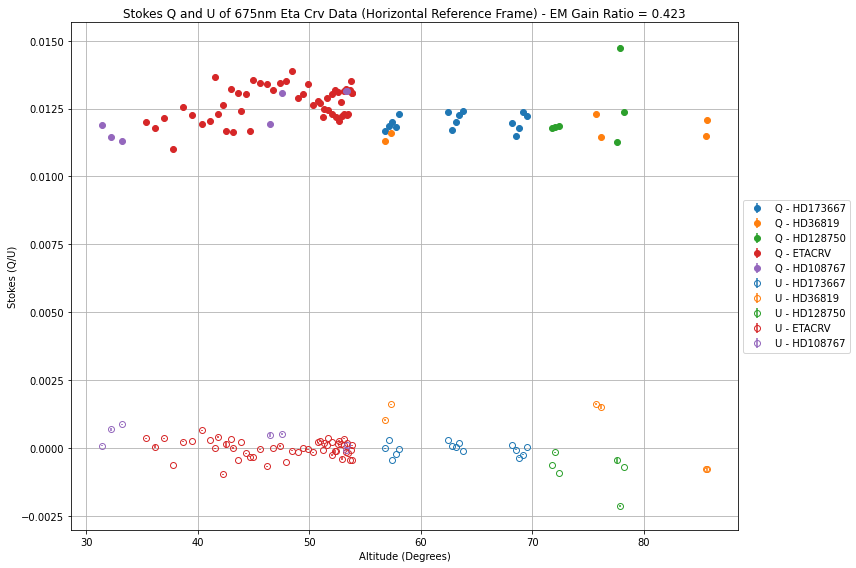

In [5]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (Horizontal Reference Frame) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Printing Some Matrices

In [6]:
# m3_with_rotations(delta_m3, epsilon_m3, offset, parang, altitude)
print(matrices.m3_with_rotations(0, 0, 0, 0, 0))
print(matrices.m3_with_rotations(0, 0.01, 0, 0, 0))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1.      0.01    0.      0.     ]
 [0.01    1.      0.      0.     ]
 [0.      0.      0.99995 0.     ]
 [0.      0.      0.      0.99995]]


In [7]:
delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0.5  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

parang = 0
altitude = 0
HWP_ang = 0
IMR_ang = 0
cam_num = 1
FLC_state = 1

# full_system_mueller_matrix( 
    # delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, delta_derot, 
    # offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    # em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state)

print(matrices.full_system_mueller_matrix( 
    delta_m3, 0.5, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state))
print((matrices.full_system_mueller_matrix( 
    delta_m3, 0.5, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state) @ np.array([1, 0, 0, 0]).reshape(-1, 1)))
print(matrices.full_system_mueller_matrix( 
    delta_m3, 0, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state))
print(matrices.full_system_mueller_matrix( 
    delta_m3, 0, -2.5, delta_HWP, offset_HWP, delta_derot, 
    offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, rot_FLC, 
    em_gain, parang, altitude, HWP_ang, IMR_ang, cam_num, FLC_state) @ np.array([1, 0, 0, 0]).reshape(-1, 1))

[[ 0.32174911  0.31521565 -0.06059112  0.02214264]
 [ 0.32174911  0.31521565 -0.06059112  0.02214264]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[0.32174911]
 [0.32174911]
 [0.        ]
 [0.        ]]
[[ 0.21885504  0.20578813 -0.06996459  0.02556812]
 [ 0.21885504  0.20578813 -0.06996459  0.02556812]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[0.21885504]
 [0.21885504]
 [0.        ]
 [0.        ]]


In [8]:

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0.5  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
epsilon_m3 = 0.25
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

model = matrices.full_system_mueller_matrix
print(matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
    model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)[0] @ np.array([1, 0, 0, 0]).reshape(-1, 1))

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
epsilon_m3 = 0.25
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix

print(matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
    model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)[0] @ np.array([1, 0, 0, 0]).reshape(-1, 1))

Fixed Params:  [0, 0.25, -2.5, 0.451, -2.642, 0.32, -0.011, -0.163, 0.036, -7.151, 0.302, 0.256, 0.423]
FL1: [[ 0.27030207  0.26050189 -0.06774293  0.02475622]
 [ 0.27030207  0.26050189 -0.06774293  0.02475622]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR1: [[ 0.36958117 -0.33147107  0.15591499 -0.04906816]
 [-0.36958117  0.33147107 -0.15591499  0.04906816]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FL2: [[ 0.18065037 -0.06172995 -0.09507247  0.14065986]
 [ 0.18065037 -0.06172995 -0.09507247  0.14065986]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR2: [[ 0.58152372  0.43030633  0.22052384 -0.32307203]
 [-0.58152372 -0.43030633 -0.22052384  0.32307203]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 0.30159425]
 [-0.12229085]
 [ 0.        ]
 [ 0.      

# Adding M3

In [9]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0.5  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
epsilon_m3 = 0.25
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

print(epsilon_m3)

0.25


Fixed Params:  [0, 0.25, -2.5, 0.451, -2.642, 0.32, -0.011, -0.163, 0.036, -7.151, 0.302, 0.256, 0.423]
FL1: [[ 0.19029226 -0.05953738 -0.1728911  -0.05267933]
 [ 0.19029226 -0.05953738 -0.1728911  -0.05267933]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR1: [[ 0.54367094  0.36488804  0.38545339  0.11773062]
 [-0.54367094 -0.36488804 -0.38545339 -0.11773062]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FL2: [[ 0.21595828  0.07950168  0.10510845 -0.17108383]
 [ 0.21595828  0.07950168  0.10510845 -0.17108383]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR2: [[ 0.48299476  0.03619049 -0.27175594  0.3976467 ]
 [-0.48299476 -0.03619049  0.27175594 -0.3976467 ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Fixed Params:  [0, 0.25, -2.5, 0.451, -2.642, 0.32, -0.0

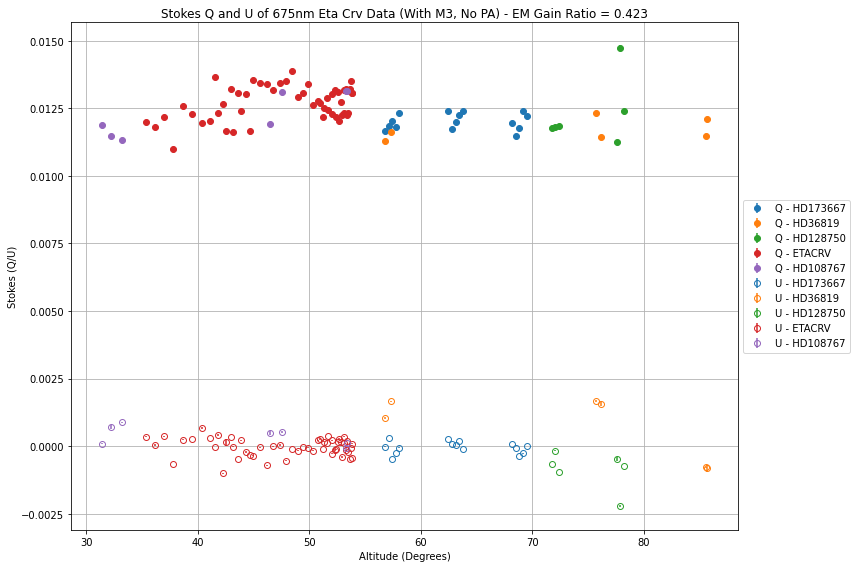

In [10]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            #print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, 0, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (With M3, No PA) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting in Equatorial Reference Frame

In [11]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0.0126  # Rough value from unpolarized standards fit
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

Parallactic Angle: -84.9084509958819 Altitude: 56.56625 HWP Angle: 0.0 IMR Angle: 92.72502
Fixed Params:  [0, 0.0126, -2.5, 0.451, -2.642, 0.32, -0.011, -0.163, 0.036, -7.151, 0.302, 0.256, 0.423]
FL1: [[ 0.21741548  0.07817119  0.19544592 -0.05440265]
 [ 0.21741548  0.07817119  0.19544592 -0.05440265]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR1: [[ 0.48568956 -0.17599758 -0.43604703  0.12158201]
 [-0.48568956  0.17599758  0.43604703 -0.12158201]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FL2: [[ 0.20949793 -0.01018761 -0.11211407 -0.17668059]
 [ 0.20949793 -0.01018761 -0.11211407 -0.17668059]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
FR2: [[ 0.50440715  0.03288848  0.29104514  0.41065515]
 [-0.50440715 -0.03288848 -0.29104514 -0.41065515]
 [ 0.          0.          0.          0.        ]
 [ 0.          

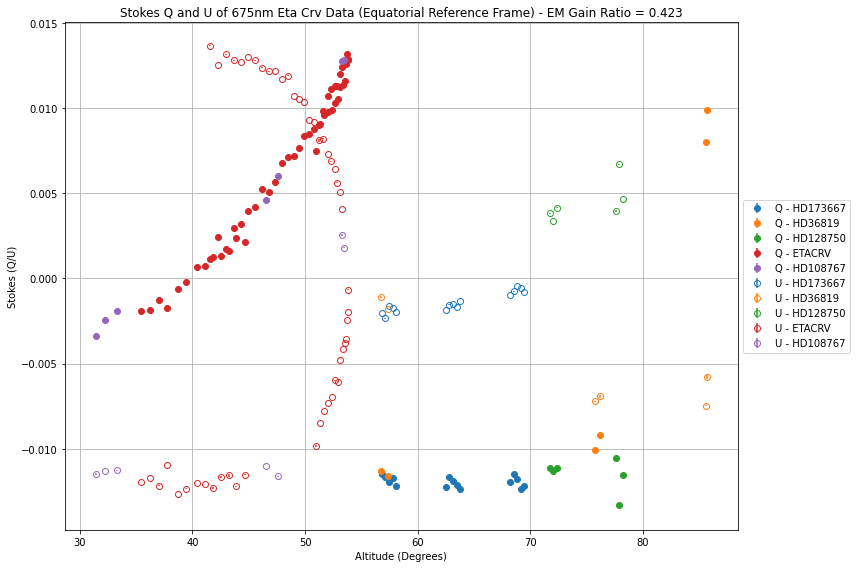

In [12]:
# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():
        HWP_ang = row["U_HWPANG"]
        IMR_ang = row["D_IMRANG"]
        cam_num = row["U_CAMERA"]
        FLC_state = row["U_FLCSTT"]
        altitude = row["ALTITUDE"]
        parang = row["PA"]
        data_Q = row["Q"]

        # NOTE: This is for normalized differences
        double_difference = row["DOUBLE_DIFFERENCE"]
        double_sum = row["DOUBLE_SUM"]
        double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

        if double_difference != 0:
            # Append intensities and altitudes for this cycle
            this_cycle_intensities.append(double_difference)
            this_cycle_altitudes.append(altitude)
            this_cycle_errors.append(double_difference_err)

            print("Parallactic Angle: " + str(parang) + " Altitude: " + str(altitude) + " HWP Angle: " + str(HWP_ang) + " IMR Angle: " + str(IMR_ang))

            # Calculate instrument matrix for equatorial reference frame
            these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
            # Calculate instrument matrix at HWP
            # these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            #     model, fixed_params, 0, 0, HWP_ang, IMR_ang, factor = double_diff_factor)
            double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
            double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

            # Setting the I component to be 1
            double_diff_matrix_at_HWP[0, 0] = 1

            # Saving instrument matrices
            inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
            inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

            # Take only the first row and I, Q, U, components (no V)
            first_rows.append(double_diff_matrix_at_HWP[0, : 3])  

        # Do one inversion for one HWP cycle
        if data_Q != 0:
            # Constructing measurement matrix to reconstruct Stokes vector at HWP
            measurement_matrix = np.vstack(first_rows)
            measurements = np.array(this_cycle_intensities).reshape(-1, 1)  # Reshape total counts to a column vector
            errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

            # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
            s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

            # Compute the errors for the Stokes parameters
            s_HWP_err = np.linalg.pinv(measurement_matrix) @ errors

            # Extract Q and U from s_HWP and their errors
            Q = s_HWP[1]
            U = s_HWP[2]
            Q_err = s_HWP_err[1]
            U_err = s_HWP_err[2]

            # Append Q, U, altitude, and errors to the lists
            Q_list.append((altitude, Q, color, obj))
            U_list.append((altitude, U, color, obj))
            Q_err_list.append(Q_err)
            U_err_list.append(U_err)

            # Saving the mean of the altitudes
            mean_altitude = np.mean(this_cycle_altitudes)

            # Reset measurement matrix rows and double diff and sum measurements
            first_rows = []  
            this_cycle_intensities = []
            this_cycle_altitudes = []
            this_cycle_errors = []

            final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data (Equatorial Reference Frame) - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
